In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-03-01 00:01:48.482220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 00:01:48.634486: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 00:01:49.366251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

,DA,DB,bA,bB,bC,bD,bE,bF,VA,VB,...,nfe,nee,neb,nce,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion
404,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,615.268976,73.210081,...,4.0,4.0,4.0,1.0,2.0,"[0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....",stable spiral,turing I oscillatory,0.004898+0.036487j,True
2726,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,228.017071,94.502643,...,4.0,4.0,4.0,1.0,2.0,"[83.3645, 0.276, 12736.8586, 66.0485, 579.5646...",stable spiral,turing I oscillatory,0.000114+0.002647j,True
3508,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,23.538028,320.885489,...,4.0,4.0,4.0,1.0,3.0,"[6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....",stable spiral,turing I oscillatory,0.001639+0.132134j,True
7516,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,16.205693,83.166774,...,4.0,4.0,4.0,1.0,1.0,"[1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...",stable spiral,turing I oscillatory,0.000652+0.003066j,True
7883,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,85.164519,738.495294,...,4.0,4.0,4.0,1.0,2.0,"[2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....",stable spiral,turing I oscillatory,0.001346+0.016362j,True


In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [89]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
dxdy = x_size*y_size/L**2
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]

x_slice = slice(45, 120, 1)
y_slice = slice(45, 120, 1)

#data = data[:, x_slice, y_slice, np.newaxis]
#x_size = data.shape[1]
#y_size = data.shape[2]
#T = 1#data.shape[3]



indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])



In [91]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

In [92]:
def create_dataset_multi_nodes(
    data,
    t_star,
    N,
    T,
    L,
    training_data_size,
    pde_data_size,    
    signal_to_noise=0,
    shuffle=True,
    derivatives=None,
    idx_data=None,
):
    x_size = data.shape[1]
    y_size = data.shape[2]
    x_domain = L * np.linspace(0, 1, x_size)
    y_domain = L * np.linspace(0, 1, y_size)

    X, Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
    XX = np.tile(X.flatten(), T)  # N x T
    YY = np.tile(Y.flatten(), T)  # N x T
    TT = np.repeat(t_star[-T:], N)  # T x N

    #UU = np.einsum("cijk->ckij", data[:, :, :, -T:])
    UU = np.einsum("cxyk->ckxy", data[:, :, :, -T:])
    UU = np.array([UU[i, :, :, :].flatten() for i in range(UU.shape[0])])  # c , N x T
    
    if derivatives is not None:
        dds = np.array([[np.einsum("ijk->kij", d[i, :, :, -T:]).flatten() for d in derivatives]
               for i in range(derivatives[0].shape[0])
              ])                  
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_u = (np.max(UU) - np.min(UU)) / 2.0
        sigma_u = signal_amp_u * signal_to_noise
    # Observed data
    if idx_data is None:
        if shuffle:
            idx_data = np.random.choice(N * T, training_data_size, replace=False)
        else:
            idx_data = list(range(training_data_size))
    # PDE colocations
    if shuffle:
        idx_pde = np.random.choice(N * T, pde_data_size, replace=False)
    else:
        idx_pde = list(range(pde_data_size))

    # Lower/Upper bounds
    lb, ub = lower_upper_bounds(np.c_[XX, YY, TT])
    if derivatives is not None:
        derivatives_lb_ub = [
            lower_upper_bounds(dd.T) for dd in dds
        ]        

    ret = {
        "obs_input": np.c_[XX[idx_data], YY[idx_data], TT[idx_data]],
        "obs_output": np.vstack([UU[i, idx_data] for i in range(UU.shape[0])]).T,
        "pde": np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]],
        "lb": lb,
        "ub": ub,
    }
    if derivatives is not None:
        ret = {
            **ret,
            **{
                "ders": dds[:, :, idx_data],
                "derivatives_lb_ub": derivatives_lb_ub,
            },
        }
    if signal_to_noise > 0:
        ret["obs_output"] += sigma_u * np.random.randn(len(idx_data))

    return ret

In [93]:
data.shape

(6, 160, 160, 1)

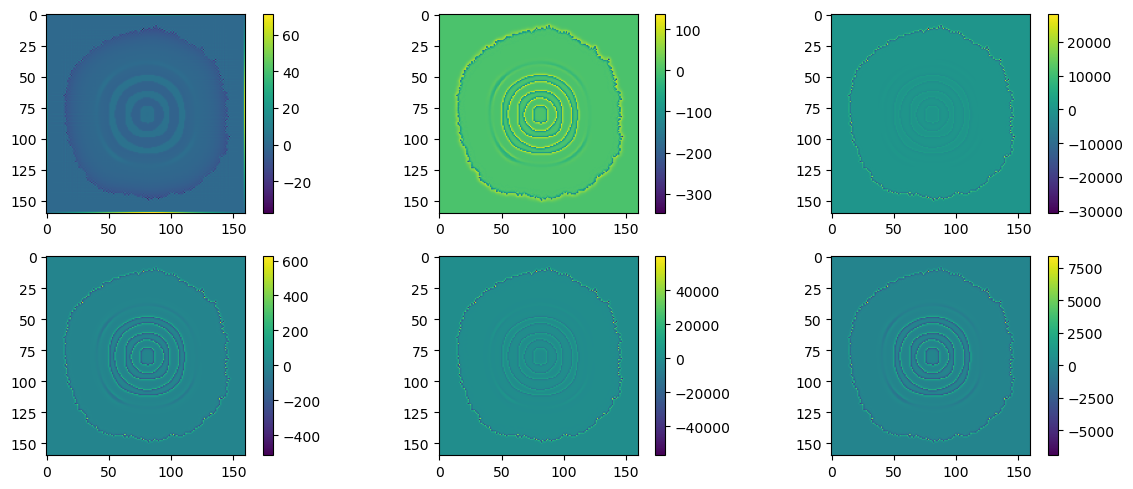

In [94]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


In [95]:
c_xx.shape

(6, 160, 160, 1)

In [96]:
data.shape

(6, 160, 160, 1)

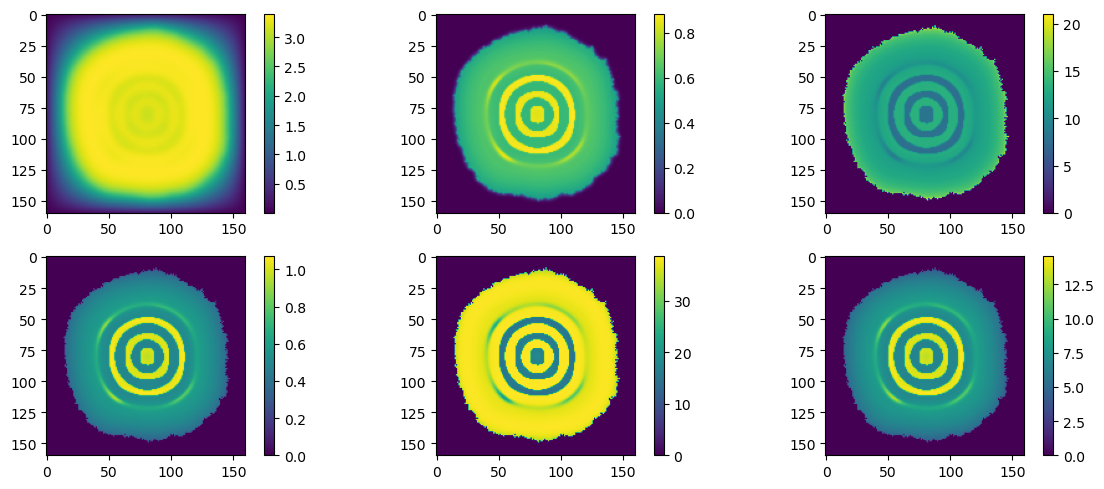

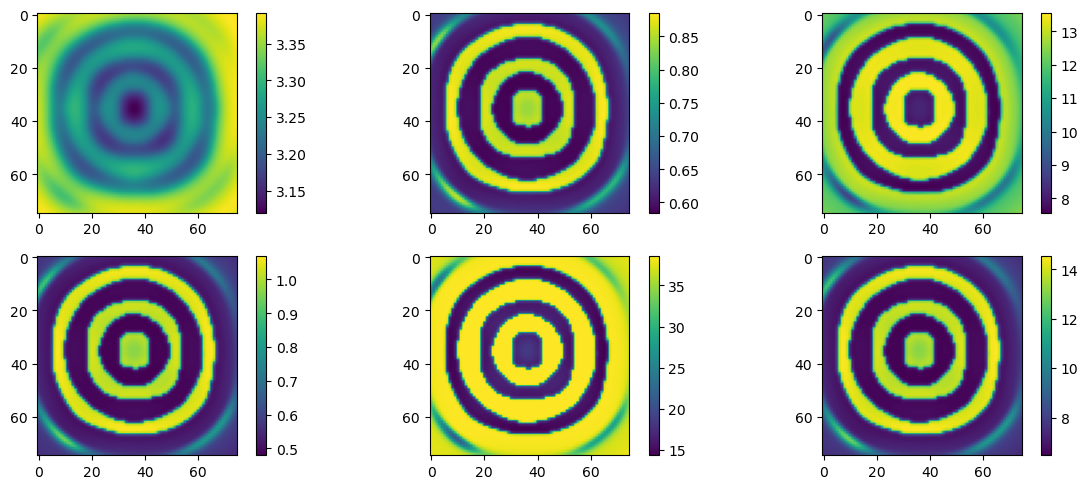

In [97]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [ ]:
c_xx.shape

In [149]:
c_restricted = data[:, x_slice, y_slice, :].copy()
c_xx_restricted = c_xx[:, x_slice, y_slice, :].copy()
c_yy_restricted = c_yy[:, x_slice, y_slice, :].copy() 
c_t_restricted = c_t[:, x_slice, y_slice, :].copy()

    
model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}


dataset = create_dataset_multi_nodes(data, t_star, N, 1, L, **model_params)
lb = dataset['lb']#[0:2]
#Since there are just one time step, we set the lb of T equal to zero
lb[-1] = 0.0
ub = dataset['ub']#[0:2]
obs_X = np.float32(dataset['obs_input'])#[:, 0:2])
obs_Y = np.float32(dataset['obs_output'])
#pde_X = np.float32(dataset['pde'])
ders_xx = np.float32(dataset['ders'][:, 0, :])
ders_yy = np.float32(dataset['ders'][:, 1, :])
ders_t = np.float32(dataset['ders'][:, 2, :])

In [150]:
lb, ub

(array([0., 0., 0.]), array([8., 8., 1.]))

In [151]:
A.shape

(160, 160)

In [152]:
obs_X.shape

(5625, 3)

In [153]:
5625/5

1125.0

In [154]:
def gen_series():    
    
    for i in range(obs_X.shape[0]):        
        yield obs_X[i,:], obs_Y[i,:], ders_xx[:, i], ders_yy[:, i], ders_t[:, i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((obs_X.shape[1],),(obs_Y.shape[1],),
                                                   (ders_xx.shape[0],),(ders_yy.shape[0],),
                                                   (ders_t.shape[0],)))

In [160]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
    
def create_pinn(layers=[3, 256, 256, 6],
                learning_rate=1e-2,
                w1=1, w2=1,w7=100, w8=100,
                DA_val=None, DB_val=None,
                bA_val=None,bB_val=None,bC_val=None,bD_val=None,bE_val=None,bF_val=None,
                VA_val=None,VB_val=None,VC_val=None,VD_val=None,VE_val=None,VF_val=None,
                Kab_val=None,Kbd_val=None,Kce_val=None,Kda_val=None,Keb_val=None,Kee_val=None,
                Kfe_val=None,muASV_val=None,muLVA_val=None,
                nab_val=None,nbd_val=None,nce_val=None,nda_val=None,nfe_val=None,
                neb_val=None,nee_val=None):    
    #lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
    #ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(name, value, no_clip=False):
        print(f"{name}: {value}")
        if no_clip:
            return tf.Variable(value,
                           dtype=pinn.dtype,
                           name=name)
        else:
            return tf.Variable(value,
                           dtype=pinn.dtype,
                           name=name,
                           constraint=clip_by_value_zero_lb)

    DA = create_tf_var("DA", DA_val if DA_val is not None else  df_params.loc[ID,:].DA)    
    DB = create_tf_var("DB", DB_val if DB_val is not None else df_params.loc[ID,:].DB)
    bA = create_tf_var("bA",  bA_val if bA_val is not None else df_params.loc[ID,:].bA)#
    bB = create_tf_var("bB",  bB_val if bB_val is not None else df_params.loc[ID,:].bB)#
    bC = create_tf_var("bC",  bC_val if bC_val is not None else df_params.loc[ID,:].bC)#
    bD = create_tf_var("bD",  bD_val if bD_val is not None else df_params.loc[ID,:].bD)#
    bE = create_tf_var("bE",  bE_val if bE_val is not None else df_params.loc[ID,:].bE)#
    bF = create_tf_var("bF",  bF_val if bF_val is not None else df_params.loc[ID,:].bF)#
    VA = create_tf_var("VA",  VA_val if VA_val is not None else df_params.loc[ID,:].VA)
    VB = create_tf_var("VB",  VB_val if VB_val is not None else df_params.loc[ID,:].VB)
    VC = create_tf_var("VC",  VC_val if VC_val is not None else df_params.loc[ID,:].VC)
    VD = create_tf_var("VD",  VD_val if VD_val is not None else df_params.loc[ID,:].VD)
    VE = create_tf_var("VE",  VE_val if VE_val is not None else df_params.loc[ID,:].VE)
    VF = create_tf_var("VF",  VF_val if VF_val is not None else df_params.loc[ID,:].VF)
    Kab = create_tf_var("Kab", Kab_val if Kab_val is not None else df_params.loc[ID,:].Kab)
    Kbd = create_tf_var("Kbd",  Kbd_val if Kbd_val is not None else  df_params.loc[ID,:].Kbd)
    Kce = create_tf_var("Kce",  Kce_val if Kce_val is not None else  df_params.loc[ID,:].Kce)
    Kda = create_tf_var("Kda",  Kda_val if Kda_val is not None else  df_params.loc[ID,:].Kda)
    Keb = create_tf_var("Keb",  Keb_val if Keb_val is not None else  df_params.loc[ID,:].Keb)
    Kee = create_tf_var("Kee",  Kee_val if Kee_val is not None else  df_params.loc[ID,:].Kee)
    Kfe = create_tf_var("Kfe",  Kfe_val if Kfe_val is not None else  df_params.loc[ID,:].Kfe)
    muASV = create_tf_var("muASV",  muASV_val if muASV_val is not None else  df_params.loc[ID,:].muASV)
    muLVA = create_tf_var("muLVA",  muLVA_val if muLVA_val is not None else  df_params.loc[ID,:].muLVA)
    nab = create_tf_var("nab",  nab_val if nab_val is not None else  df_params.loc[ID,:].nab)
    nbd = create_tf_var("nbd",  nbd_val if nbd_val is not None else  df_params.loc[ID,:].nbd)
    nce = create_tf_var("nce",  nce_val if nce_val is not None else  df_params.loc[ID,:].nce)
    nda = create_tf_var("nda",  nda_val if nda_val is not None else  df_params.loc[ID,:].nda)
    nfe = create_tf_var("nfe",  nfe_val if nfe_val is not None else  df_params.loc[ID,:].nfe)
    neb = create_tf_var("neb",  neb_val if neb_val is not None else  df_params.loc[ID,:].neb)
    nee = create_tf_var("nee",  nee_val if nee_val is not None else  df_params.loc[ID,:].nee)
    
    w1 = create_tf_var("w1",  w1)
    w2 = create_tf_var("w2",  w2)    
    w7 = create_tf_var("w7",  w7)
    w8 = create_tf_var("w8",  w8)

    params_trainable = ( 
                      ((DA,) if DA_val is not None else ())
                    + ((DB,) if DB_val is not None else ())
                    + ((bA,) if bA_val is not None else ())
                    + ((bB,) if bB_val is not None else ())
                    + ((bC,) if bC_val is not None else ())
                    + ((bD,) if bD_val is not None else ())
                    + ((bE,) if bE_val is not None else ())
                    + ((bF,) if bF_val is not None else ())
                    + ((VA,) if VA_val is not None else ())
                    + ((VB,) if VB_val is not None else ())
                    + ((VC,) if VC_val is not None else ())
                    + ((VD,) if VD_val is not None else ())
                    + ((VE,) if VE_val is not None else ())
                    + ((VF,) if VF_val is not None else ())
                    + ((Kab,) if Kab_val is not None else ())
                    + ((Kbd,) if Kbd_val is not None else  ())
                    + ((Kce,) if Kce_val is not None else  ())
                    + ((Kda,) if Kda_val is not None else  ())
                    + ((Keb,) if Keb_val is not None else  ())
                    + ((Kee,) if Kee_val is not None else  ())
                    + ((Kfe,) if Kfe_val is not None else  ())
                    + ((muASV,) if muASV_val is not None else  ())
                    + ((muLVA,) if muLVA_val is not None else  ())
                    + ((nab,) if nab_val is not None else  ())
                    + ((nbd,) if nbd_val is not None else  ())
                    + ((nce,) if nce_val is not None else  ())
                    + ((nda,) if nda_val is not None else  ())
                    + ((nfe,) if nfe_val is not None else  ())
                    + ((neb,) if neb_val is not None else  ())
                    + ((nee,) if nee_val is not None else  ())
                      )
    

    #@tf.function
    def train_step_inverse(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
                Cg = tf.squeeze(outputs[:, 2])
                Dg = tf.squeeze(outputs[:, 3])
                Eg = tf.squeeze(outputs[:, 4])
                Fg = tf.squeeze(outputs[:, 5])

                grad_A = tape2.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]
                grad_B = tape2.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0] 
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            A = tf.squeeze(elements[1][:, 0])
            B = tf.squeeze(elements[1][:, 1])
            C = tf.squeeze(elements[1][:, 2])
            D = tf.squeeze(elements[1][:, 3])
            E = tf.squeeze(elements[1][:, 4])
            F = tf.squeeze(elements[1][:, 5]) 

            act_A_xx = elements[2][:, 0]
            act_B_xx = elements[2][:, 1]
            act_A_yy = elements[3][:, 0]
            act_B_yy = elements[3][:, 1]

    #         act_A_t = elements[4][:, 0]
    #         act_B_t = elements[4][:, 1]
    #         act_C_t = elements[4][:, 2]
    #         act_D_t = elements[4][:, 3]
    #         act_E_t = elements[4][:, 4]
    #         act_F_t = elements[4][:, 5]


            def activate(x, km, n=2):
                # ex = (km / (x + 1e-20)) ** (n)
                # tf.math.is_inf(ex)
                act = 1 / (1 + (km / (x + 1e-20)) ** (n))
                return act

            def inhibit(x, km, n=2):
                inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
                return inh

            A_rhs = DA * (A_xx + A_yy)# - u_t
            B_rhs = DB * (B_xx + B_yy)# - v_t
            
            f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
            f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
            f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
            f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
            f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
            f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F
    #         f_C =  -act_C_t - bC - VC * inhibit(D, Kda, nda) + muLVA * C
    #         f_D =  -act_D_t - bD - VD * activate(B, Kbd, nbd) + muLVA * D
    #         f_E =  -act_E_t - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
    #         f_F =  -act_F_t - bF - VF * activate(B, Kbd, nbd) + muLVA * F

            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)
            l2_res_D = tf.reduce_sum(f_D**2)
            l2_res_E = tf.reduce_sum(f_E**2)
            l2_res_F = tf.reduce_sum(f_F**2)

            act_A_rhs = DA*(act_A_xx + act_A_yy) #- act_A_t
            act_B_rhs = DB*(act_B_xx + act_B_yy) #- act_B_t
            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            #l2 = (w1*l2_res_A + w2*l2_res_B + 
            #      w7*l2_res_A_rhs + w8*l2_res_B_rhs)
            #l2 = l2_res_A + l2_res_B  + l2_res_A_rhs + l2_res_B_rhs
            
            l2 = l2_res_A_rhs + l2_res_B_rhs

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w7, w8)

In [194]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w7, w8) = create_pinn(
    learning_rate=2e-3, w1=0, w2=0, w7=1, w8=1
)


DA: 1.0
DB: 0.001
bA: 0.01
bB: 0.01
bC: 0.01
bD: 0.01
bE: 0.01
bF: 0.01
VA: 46.73334740413522
VB: 134.69781903853504
VC: 53.67775762072485
VD: 44.231762922444815
VE: 943.265620044018
VF: 605.0266911107649
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 4.247713917996289
muLVA: 1.4288264760159275
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0
w1: 0
w2: 0
w7: 1
w8: 1


In [195]:
obs_X.shape

(5625, 3)

In [196]:
losses1 = tu.train(epochs=30000+1,
                  batch_size=5625,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 80534.35931915045
l2_res_A: 39072.15234375, l2_res_B: 11.50661755, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 39082.98437500, l2_res_B_rhs: 10.80145931

Time taken: 7.32s

Start of epoch 500
at epoch 500, total loss: 19901.57452148199
l2_res_A: 11674.31738281, l2_res_B: 10.93366241, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 5849.17773438, l2_res_B_rhs: 10.23121834

Time taken: 105.77s

Start of epoch 1000
at epoch 1000, total loss: 19151.748573720455
l2_res_A: 11846.07519531, l2_res_B: 10.87417507, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 4927.76660156, l2_res_B_rhs: 10.11807823

Time taken: 102.69s

Start of epoch 1500
at epoch 1500, total loss: 18665.606927335262
l2_res_A: 11664.68359375, l2_res_B: 10.81734467, l2_res_C: 67.44142151, l2_res_D: 0.98


Start of epoch 14500
at epoch 14500, total loss: 15600.403209626675
l2_res_A: 12580.30859375, l2_res_B: 12.78944969, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 644.90039062, l2_res_B_rhs: 5.49025202

Time taken: 109.01s

Start of epoch 15000
at epoch 15000, total loss: 15507.933370530605
l2_res_A: 12531.50195312, l2_res_B: 12.84885120, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 601.37811279, l2_res_B_rhs: 5.28992987

Time taken: 108.51s

Start of epoch 15500
at epoch 15500, total loss: 15740.554474771023
l2_res_A: 12785.41601562, l2_res_B: 12.97887421, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 580.13500977, l2_res_B_rhs: 5.11005163

Time taken: 109.34s

Start of epoch 16000
at epoch 16000, total loss: 15446.665270268917
l2_res_A: 12524.79101562, l2_res_B: 12.97955322, l2_res_C: 67.44142151, l


Start of epoch 29000
at epoch 29000, total loss: 15476.034896314144
l2_res_A: 12841.82226562, l2_res_B: 14.02874851, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 259.88754272, l2_res_B_rhs: 3.38181591

Time taken: 109.40s

Start of epoch 29500
at epoch 29500, total loss: 15685.404699265957
l2_res_A: 13052.88867188, l2_res_B: 14.05598354, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 258.19738770, l2_res_B_rhs: 3.34813261

Time taken: 108.64s

Start of epoch 30000
at epoch 30000, total loss: 15643.506380021572
l2_res_A: 13022.89453125, l2_res_B: 14.15343285, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 246.24032593, l2_res_B_rhs: 3.30356646

Time taken: 105.12s


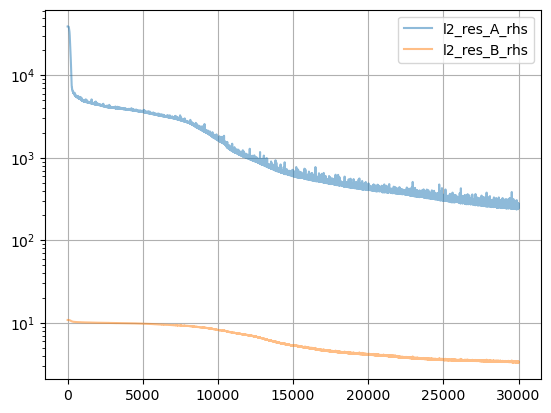

In [198]:
for i, n in enumerate(names[-2:]):
    plt.plot(losses1[:,6+i], label=n, alpha=.5)
plt.legend();plt.grid();plt.yscale('log');plt.show()

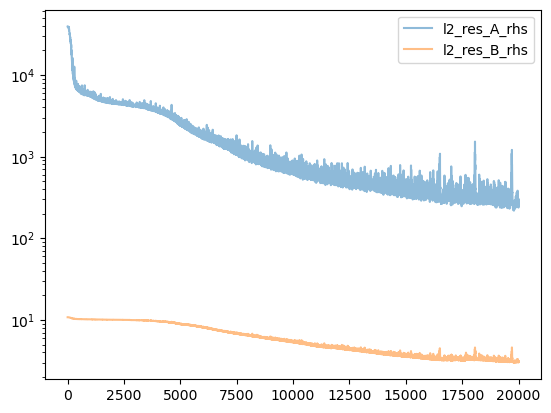

In [172]:
for i, n in enumerate(names[-2:]):
    plt.plot(losses1[:,6+i], label=n, alpha=.5)
plt.legend();plt.yscale('log');plt.show()

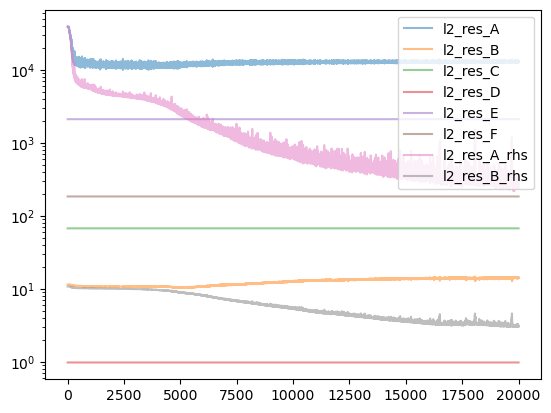

In [174]:
for i, n in enumerate(names):
    plt.plot(losses1[:,i], label=n, alpha=.5)        
plt.legend();plt.yscale('log');plt.show()

In [184]:
losses2 = tu.train(epochs=10000+1,
                  batch_size=5625,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 15273.499401032925
l2_res_A: 12616.51953125, l2_res_B: 14.33124352, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 282.60974121, l2_res_B_rhs: 3.12436152

Time taken: 3.36s

Start of epoch 500
at epoch 500, total loss: 15299.32016891241
l2_res_A: 12669.41992188, l2_res_B: 14.15079880, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 255.74913025, l2_res_B_rhs: 3.08579445

Time taken: 102.47s

Start of epoch 1000
at epoch 1000, total loss: 15628.16910547018
l2_res_A: 13054.33593750, l2_res_B: 14.29393387, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 199.69337463, l2_res_B_rhs: 2.93133593

Time taken: 101.97s

Start of epoch 1500
at epoch 1500, total loss: 15523.714255273342
l2_res_A: 12853.24804688, l2_res_B: 14.18305588, l2_res_C: 67.44142151, l2_res_D: 0.98457664,

In [226]:
np.min(losses1[:,6]),np.min(losses1[:,7])

(236.0714111328125, 3.3005526065826416)

In [227]:
np.min(losses2[:,6]),np.min(losses2[:,7])

(141.30551147460938, 2.729440212249756)

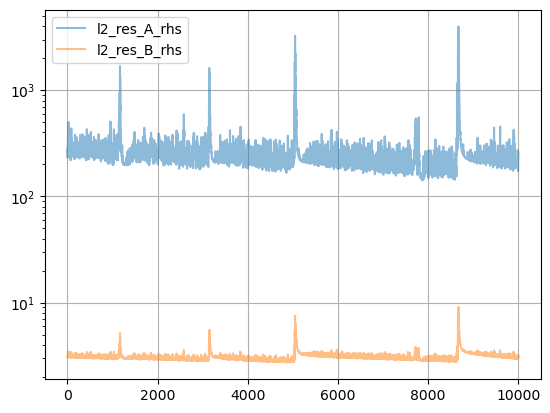

In [199]:
for i, n in enumerate(names[-2:]):
    plt.plot(losses2[:,6+i], label=n, alpha=.5)
        
plt.legend();plt.grid()
plt.yscale('log')
plt.show()

In [190]:
optimizer1.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [192]:
optimizer1.lr.assign(1e-3)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [193]:
losses3 = tu.train(epochs=5000+1,
                  batch_size=5625,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 15815.075550496578
l2_res_A: 13184.52050781, l2_res_B: 14.48206711, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 256.08694458, l2_res_B_rhs: 3.07150745

Time taken: 3.10s

Start of epoch 500
at epoch 500, total loss: 15473.586809813976
l2_res_A: 12938.29687500, l2_res_B: 14.32722378, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 161.11717224, l2_res_B_rhs: 2.93101525

Time taken: 105.01s

Start of epoch 1000
at epoch 1000, total loss: 15468.524578988552
l2_res_A: 12935.77148438, l2_res_B: 14.33959198, l2_res_C: 67.44142151, l2_res_D: 0.98457664, l2_res_E: 2104.27124023, l2_res_F: 184.21728516, l2_res_A_rhs: 158.58268738, l2_res_B_rhs: 2.91629171

Time taken: 104.68s

Start of epoch 1500
at epoch 1500, total loss: 15465.295853555202
l2_res_A: 12935.27832031, l2_res_B: 14.35274029, l2_res_C: 67.44142151, l2_res_D: 0.9845766

KeyboardInterrupt: 

In [203]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, inputs)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]
            A_t = grad_A[:, 2]

            grad_B = tape2.gradient(Bg, inputs)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            B_t = grad_B[:, 2]
            
#             grad_C = tape2.gradient(Cg, inputs)
#             C_t = grad_C[:, 2]
            
#             grad_D = tape2.gradient(Dg, inputs)
#             D_t = grad_D[:, 2]
            
#             grad_E = tape2.gradient(Eg, inputs)
#             E_t = grad_E[:, 2]
            
#             grad_F = tape2.gradient(Fg, inputs)
#             F_t = grad_F[:, 2]
            

        grad_A_x = tape.gradient(A_x, inputs)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, inputs)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, inputs)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, inputs)
        B_yy = grad_B_y[:, 1]
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg), 
            tf.squeeze(Dg), 
            tf.squeeze(Eg), 
            tf.squeeze(Fg))                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state(pinn):
        (A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn, obs_X)
        
        A_der = DA*( to(A_xx) + to(A_yy))
        B_der = DB*( to(B_xx) + to(B_yy))

        actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        A_der = A_der
        B_der = B_der
        
        plot_n_im([to(A), c_restricted[0,:, : , -1], to(B), c_restricted[1,:, :  , -1]], 
          ["A", "Actual A", "B", "Actual B"],          
          figsize=(12, 3)); plt.tight_layout()

        A = c_restricted[0,:, : , -1]
        B = c_restricted[1,:, : , -1]

        
        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

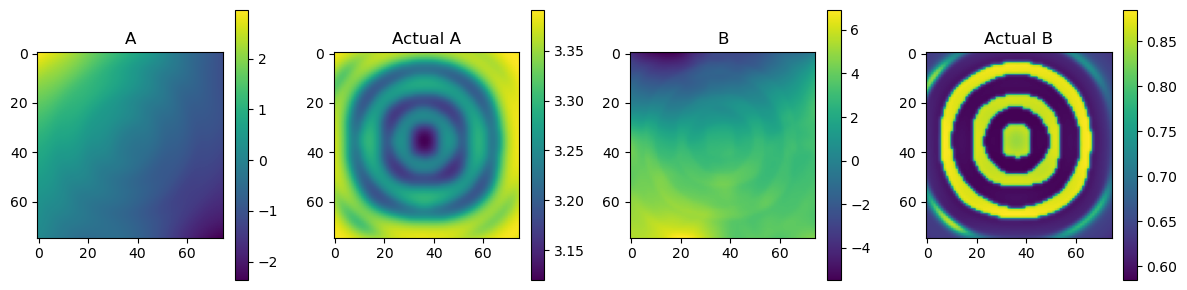

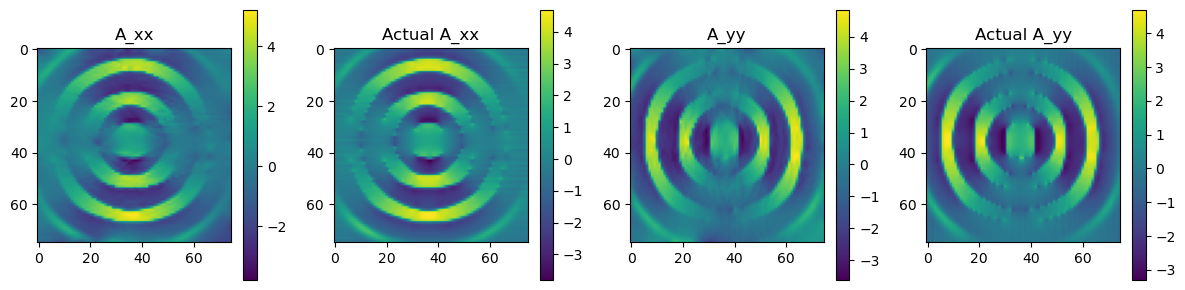

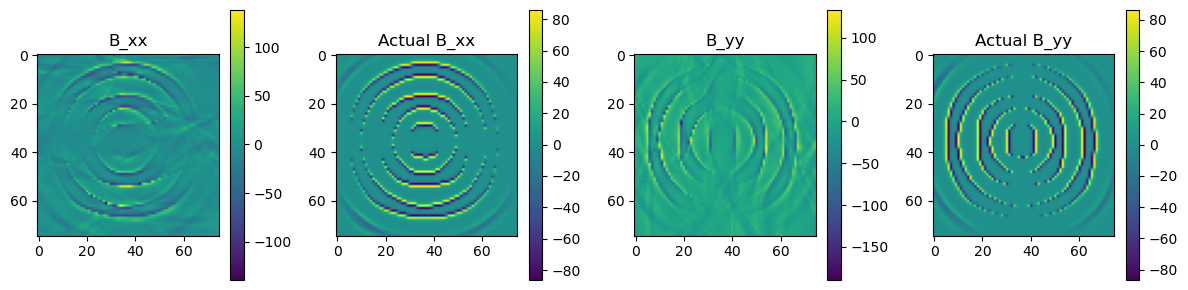

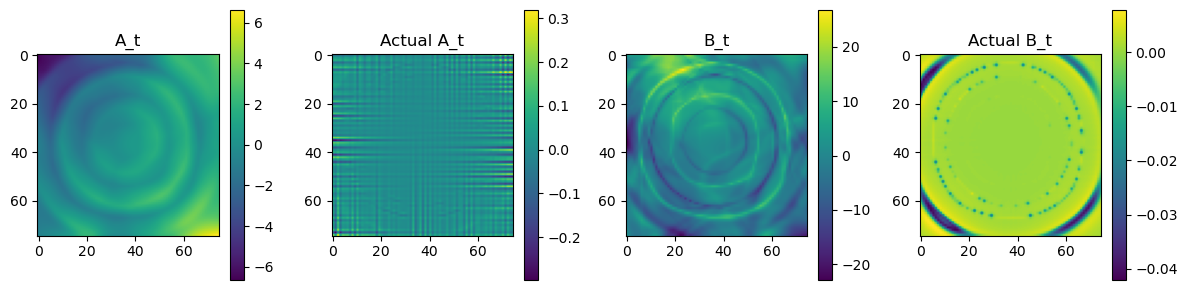

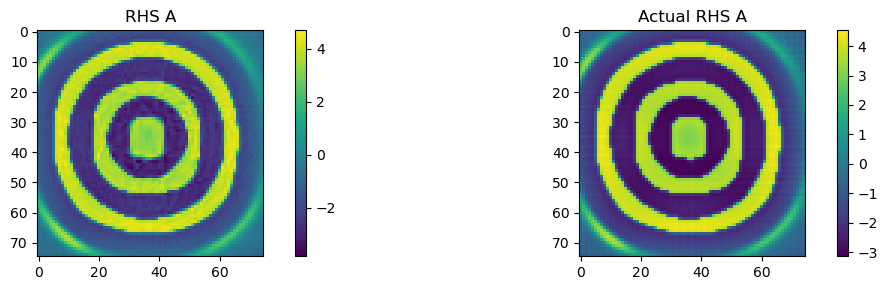

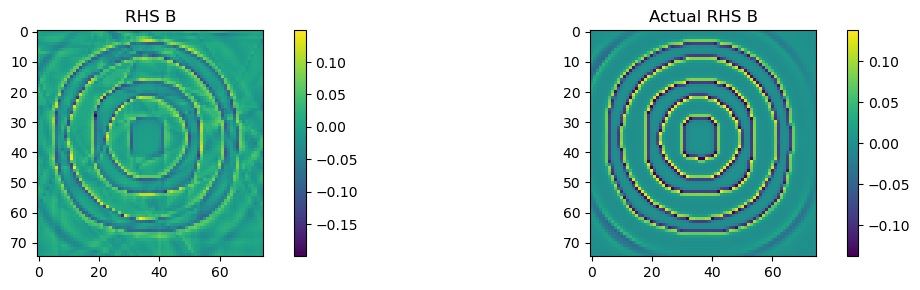

In [204]:
plot_state(pinn1)

3105.4978471716036


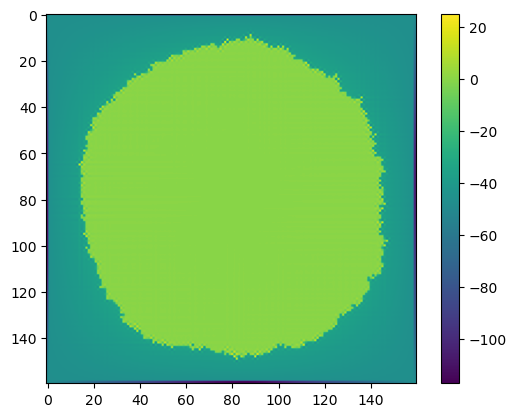

In [139]:
f_Ac = f_A.copy()
#f_Ac[f_Ac < 0] = -100
plt.imshow(f_Ac)
plt.colorbar()
print(np.sum(f_E**2))

In [205]:
(A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn1, obs_X)

In [189]:
u_t_act = c_t[0,x_slice, y_slice , -1]
v_t_act = c_t[1,x_slice, y_slice , -1]
print(np.sum(u_t_act**2))
print(np.sum(v_t_act**2))
print(np.sum(ders_t[0, :]**2))
print(np.sum(ders_t[1, :]**2))

17.003853354434494
0.29734484723934157
17.003853
0.29734483


In [206]:
A_der = DA*( to(A_xx) + to(A_yy))
B_der = DB*( to(B_xx) + to(B_yy))

actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]

In [225]:
print(np.sum((A_der-actual_A_der)**2))
print(np.sqrt(np.mean((A_der-actual_A_der)**2)))
print(np.mean(np.abs(A_der-actual_A_der)/np.abs(actual_A_der)))
print(np.sum((B_der-actual_B_der)**2))
print(np.sqrt(np.mean((B_der-actual_B_der)**2)))
print(np.mean(np.abs(B_der-actual_B_der)/np.abs(actual_B_der)))

245.65122498042973
0.20897686208145083
0.12227757893723198
3.3453351423128455
0.024387009811009705
86.66866527691492
